In [14]:
import os, shutil
import tensorflow as tf
import pandas as pd
import numpy as np
import itertools

from sklearn.utils import shuffle
from google.colab import files
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.optimizers.legacy import Nadam
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

In [2]:
!rm -rf dataset xception_model.h5 sample_data base_dir *.json && mkdir dataset

In [3]:
!pip install -q kaggle

files.upload()

!mkdir -p ~/.kaggle

!cp kaggle.json ~/.kaggle/

!sudo chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c histopathologic-cancer-detection && kaggle datasets list

Saving kaggle.json to kaggle.json
100% 6.31G/6.31G [03:32<00:00, 38.1MB/s]
100% 6.31G/6.31G [03:32<00:00, 31.9MB/s]
ref                                                                title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
zusmani/pakistan-toshakhana-files                                  Pakistan ToshaKhana Files                             1MB  2023-03-15 16:25:43           2112         77  1.0              
ramkrijal/tomato-daily-prices                                      Tomato Daily Prices                                  10KB  2023-03-10 15:39:14            905         31  1.0              
themrityunjaypathak/covid-cases-and-deaths-worldwide               Covid Cases and Deaths WorldWide                     

In [4]:
!unzip './histopathologic-cancer-detection.zip' -d './dataset'

Streaming output truncated to the last 5000 lines.
  inflating: ./dataset/train/fa2c657eff58b6802cb32843caa2fac25b67c2c9.tif  
  inflating: ./dataset/train/fa2c775c4457d0aeb7e57216849eef5f4e72e566.tif  
  inflating: ./dataset/train/fa2c77e1707c2fe7b0016e00736fb6e4b7f09488.tif  
  inflating: ./dataset/train/fa2ce5e802dd281bd98fcfb538e80b9c96c2b7af.tif  
  inflating: ./dataset/train/fa2d24e4a109d2d3a925890aaed4e0f038dfffb0.tif  
  inflating: ./dataset/train/fa2d7e4865aa7869d2dd85116323b8405c94f1c2.tif  
  inflating: ./dataset/train/fa2d8b2e4acf46e278e2e7acbc034c263d970737.tif  
  inflating: ./dataset/train/fa2df9148831509a181797db79eb1a7bf39593f1.tif  
  inflating: ./dataset/train/fa2e6db0b35484797f58005e3a6e24ca75fbca76.tif  
  inflating: ./dataset/train/fa2e80e84594465329bdc0c8d1b3a507275fbb4d.tif  
  inflating: ./dataset/train/fa2eaf8ec6267fa928a88775dc15ee25b633c537.tif  
  inflating: ./dataset/train/fa2ebf31ff5954570526d4835ac5368fabc1f035.tif  
  inflating: ./dataset/train/fa2efd2d

In [5]:
# Visualize dataset
# Reference: https://www.kaggle.com/code/taylorkern/tk-hcd-vgg19

def display_images(df):
  train_path = "./dataset/train"

  sample = df.sample(n=16).reset_index()

  plt.figure(figsize=(6,6))

  for i, row in sample.iterrows():

      img = mpimg.imread(f'./dataset/train/{row.id}.tif')    
      label = row.label

      plt.subplot(4,4,i+1)
      plt.imshow(img)
      plt.text(0, -5, f'Class {label}', color='k')
          
      plt.axis('off')

  plt.tight_layout()
  plt.show()

In [6]:
# Read .csv files folder
path = './dataset'

train_csv_file = path + '/train_labels.csv'

def process_images(csv_path, train_dir, val_dir, sample_size):
  df = pd.read_csv(csv_path)

  display_images(pd.read_csv(csv_path))

  df_1 = df[df['label'] == 0].sample(sample_size, random_state=10)
  df_2 = df[df['label'] == 1].sample(sample_size, random_state=10)
  
  df = pd.concat([df_1, df_2], axis=0).reset_index(drop=True)

  shuffled_df = shuffle(df)

  df.set_index('id', inplace=True)

  y = shuffled_df['label']

  train_df, val_df = train_test_split(shuffled_df, test_size=0.20, random_state=10, stratify=y)

  df_list_train = list(train_df['id'])

  for item in df_list_train:
    target=df.loc[item, 'label']

    if target == 1:
      imagelabel = 'tumor'
    if target == 0:
      imagelabel = 'notumor'

    src=os.path.join('./dataset/train', item+'.tif')
    dst=os.path.join(train_dir, imagelabel, item+'.tif')

    try:
      shutil.copyfile(src, dst)
    except FileNotFoundError:
      continue

  df_list_val = list(val_df['id'])

  for item in df_list_val:
    target=df.loc[item, 'label']

    if target == 1:
      imagelabel = 'tumor'
    if target == 0:
      imagelabel = 'notumor'

    src=os.path.join('./dataset/train', item+'.tif')
    dst=os.path.join(val_dir, imagelabel, item+'.tif')

    try:
      shutil.copyfile(src, dst)
    except FileNotFoundError:
      continue
  
  # return the dataframe
  return train_df, val_df


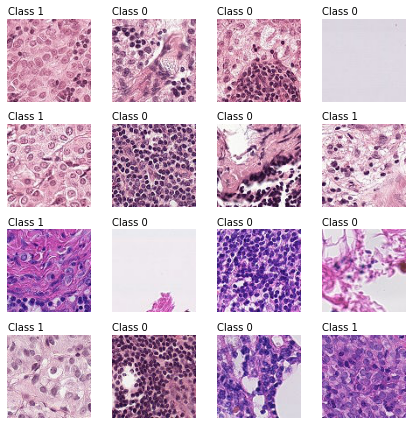

Number of tumor train images 40000
Number of notumor train images 40000


Number of tumor val images 10000
Number of notumor val images 10000


In [11]:
# make the base directory 
base_dir = 'base_dir'
os.mkdir(base_dir)

# Create a train directory
train_dir = 'base_dir/train_dir'
os.mkdir(train_dir)

tumor = os.path.join(train_dir, 'tumor')
os.mkdir(tumor)
notumor = os.path.join(train_dir, 'notumor')
os.mkdir(notumor)

# Create a val directory
val_dir = 'base_dir/val_dir'
os.mkdir(val_dir)

tumor = os.path.join(val_dir, 'tumor')
os.mkdir(tumor)
notumor = os.path.join(val_dir, 'notumor')
os.mkdir(notumor)

# Sample images and move them to their respective validation and train directories
train_df, val_df = process_images(train_csv_file, train_dir, val_dir, 50000)

print('Number of tumor train images', len(os.listdir('base_dir/train_dir/tumor')))
print('Number of notumor train images', len(os.listdir('base_dir/train_dir/notumor')))
print('\n')
print('Number of tumor val images', len(os.listdir('base_dir/val_dir/tumor')))
print('Number of notumor val images', len(os.listdir('base_dir/val_dir/notumor')))

In [12]:
# Ready the Generators
image_size=96

train_sample_count=len(os.listdir('base_dir/train_dir/tumor'))+len(os.listdir('base_dir/train_dir/notumor'))
val_sample_count=len(os.listdir('base_dir/val_dir/tumor'))+len(os.listdir('base_dir/val_dir/notumor'))

train_batch_size=14
val_batch_size=14
val_unshuffled_batch_size=1

train_steps = np.floor(train_sample_count / train_batch_size)
val_steps = np.floor(val_sample_count / val_batch_size)

datagen=ImageDataGenerator(rescale=1.0/255)

train_gen=datagen.flow_from_directory(
    train_dir,
    target_size=(image_size, image_size),
    batch_size=train_batch_size,
    class_mode='categorical'
)

val_gen=datagen.flow_from_directory(
    val_dir,
    target_size=(image_size, image_size),
    batch_size=val_batch_size,
    class_mode='categorical'
)

val_gen_unshuffled=datagen.flow_from_directory(
    val_dir,
    target_size=(image_size, image_size),
    batch_size=val_unshuffled_batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 80000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [16]:
from keras.applications.xception import Xception

dropout_dense=0.5

input_shape=(image_size, image_size, 3)

xception_base_model = Xception(
    weights='imagenet', 
    include_top=False,
    input_shape=input_shape
    )

xception_base_model.trainable = False

# Architecture inspired by https://www.kaggle.com/code/taylorkern/tk-hcd-vgg16-v01
model = Sequential([
    xception_base_model,
    BatchNormalization(),
    Flatten(),
    Dense(16, activation='relu'),
    Dropout(dropout_dense),
    Dense(8, activation='relu'),
    Dropout(dropout_dense),
    BatchNormalization(),
    Dense(2, activation='softmax')
])


model.compile(
    Nadam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 batch_normalization_8 (Batc  (None, 3, 3, 2048)       8192      
 hNormalization)                                                 
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 16)                294928    
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                      

In [17]:
# Train the Model
filepath = "xception_model.h5"

checkpoint=ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

reduce_lr=ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, verbose=1, mode='max', min_lr=0.00001)
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit(
                    train_gen, 
                    steps_per_epoch=train_steps,
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=25,
                    verbose=1,
                    callbacks=callbacks_list
                    )

Epoch 1/25
5712/5714 [============================>.] - ETA: 0s - loss: 0.6567 - accuracy: 0.6329
Epoch 1: val_accuracy improved from -inf to 0.78912, saving model to xception_model.h5
5714/5714 [==============================] - 224s 37ms/step - loss: 0.6567 - accuracy: 0.6328 - val_loss: 0.5316 - val_accuracy: 0.7891 - lr: 1.0000e-04
Epoch 2/25
5712/5714 [============================>.] - ETA: 0s - loss: 0.5841 - accuracy: 0.6963
Epoch 2: val_accuracy improved from 0.78912 to 0.80432, saving model to xception_model.h5
5714/5714 [==============================] - 178s 31ms/step - loss: 0.5842 - accuracy: 0.6964 - val_loss: 0.5093 - val_accuracy: 0.8043 - lr: 1.0000e-04
Epoch 3/25
5713/5714 [============================>.] - ETA: 0s - loss: 0.5593 - accuracy: 0.7170
Epoch 3: val_accuracy improved from 0.80432 to 0.80672, saving model to xception_model.h5
5714/5714 [==============================] - 177s 31ms/step - loss: 0.5593 - accuracy: 0.7170 - val_loss: 0.4836 - val_accuracy: 0.80

In [18]:
model.load_weights('xception_model.h5')
model.metrics_names
val_loss, val_acc = model.evaluate(val_gen_unshuffled, steps=val_sample_count, verbose=1)

print('val_loss:', val_loss)
print('val_acc:', val_acc)

20000/20000 [==============================] - 221s 11ms/step - loss: 0.3871 - accuracy: 0.8362
val_loss: 0.38710829615592957
val_acc: 0.8361999988555908


<Figure size 432x288 with 0 Axes>

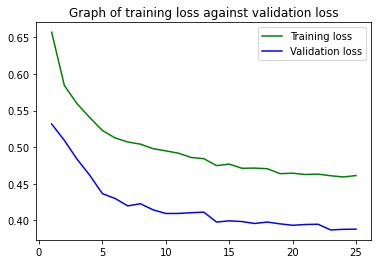

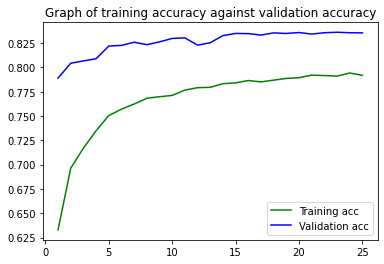

<Figure size 432x288 with 0 Axes>

In [19]:
import matplotlib.pyplot as plt

acc=history.history["accuracy"]
val_acc=history.history["val_accuracy"]
loss=history.history["loss"]
val_loss=history.history["val_loss"]

epochs=range(1, len(acc)+1)

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Graph of training loss against validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Graph of training accuracy against validation accuracy')
plt.legend()
plt.figure()

In [20]:
# make predictions using the test images
predictions=model.predict(val_gen_unshuffled, steps=val_sample_count, verbose=1)
predictions.shape
pred_df=pd.DataFrame(predictions, columns=['notumor', 'tumor'])

pred_df.head()

# Retrieve the true labels
y_true=val_gen_unshuffled.classes

# Retrieve the AUC score
y_pred=pred_df['tumor']

roc_auc_score(y_true, y_pred)

20000/20000 [==============================] - 196s 10ms/step


0.916546555

In [21]:
# Reference: Scikit Learn website
# http://scikit-learn.org/stable/auto_examples/
# model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-
# selection-plot-confusion-matrix-py


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[8797 1203]
 [2073 7927]]


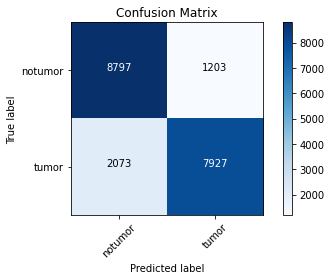

In [22]:
from sklearn.metrics._plot.confusion_matrix import confusion_matrix

test_labels=val_gen_unshuffled.classes
test_labels.shape

conf_matrix=confusion_matrix(test_labels, predictions.argmax(axis=1))
conf_matrix_plot_labels=['notumor', 'tumor']

plot_confusion_matrix(conf_matrix, conf_matrix_plot_labels, title='Confusion Matrix')

In [23]:
# Prepare classification report

from sklearn.metrics import classification_report

y_pred_binary=predictions.argmax(axis=1)

report=classification_report(y_true, y_pred_binary, target_names=conf_matrix_plot_labels)

print(report)

              precision    recall  f1-score   support

     notumor       0.81      0.88      0.84     10000
       tumor       0.87      0.79      0.83     10000

    accuracy                           0.84     20000
   macro avg       0.84      0.84      0.84     20000
weighted avg       0.84      0.84      0.84     20000



In [24]:
def process_test_images(test_dir, test_images):
  count=5000

  for image in test_images:
    if(count != 0):
      src=os.path.join('./dataset/test', image)
      dst=os.path.join(test_dir, image)

      try:
        shutil.copyfile(src, dst)
        count-=1
      except FileNotFoundError:
        continue
    else:
      break;


In [25]:
!rm -rf './base_dir/test_dir'

# Create a test directory
test_base_dir = './base_dir/test_dir'
os.mkdir(test_base_dir)
test_dir = './base_dir/test_dir/images'
os.mkdir(test_dir)

process_test_images(test_dir, os.listdir('./dataset/test'));

test_gen=datagen.flow_from_directory(
    test_base_dir,
    target_size=(image_size, image_size),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

test_image_count=len(os.listdir(test_dir))
model.load_weights('xception_model.h5')

predictions=model.predict(test_gen, steps=test_image_count, verbose=1)

pred_df=pd.DataFrame(predictions, columns=['notumor', 'tumor'])

test_filenames=test_gen.filenames
pred_df['filename']=test_filenames
pred_df.head()

Found 5000 images belonging to 1 classes.
5000/5000 [==============================] - 49s 10ms/step


,notumor,tumor,filename
0,0.475392,0.524608,images/0010e7eaa3d8e14203cd3900b739d8bf0f0b67f...
1,0.998360,0.001639,images/003c82a3fd4d552af6da029f09ed1824894fd6f...
2,0.011158,0.988842,images/003d14ca5481028a008c34b6cca7c235dcc1d29...
3,0.721222,0.278778,images/005378cea8f2e0338f45d7cc77f3d60e4292725...
4,0.650287,0.349713,images/0058dab0652de23878eef583f4635b19b59dc59...


In [26]:
def extract_filename(strg):
  str1=strg.split('/')
  return str1[1]

pred_df['filename']=pred_df['filename'].apply(extract_filename)

y_pred = pred_df['tumor']
filename=pred_df['filename']

# Create a submission file
submission=pd.DataFrame({
    'filename': filename,
    'class': y_pred, 
}).set_index('filename')

submission.to_csv('xception_preds.csv', columns=['class'])

submission.tail()

,class
filename,
ff50793ad6d8838830b47e5f71627e7dea7d4875.tif,0.374888
ff5c337a8be7667d59d5b143afcba9f797e5b923.tif,0.439710
ff84572a68341ce9c071fd2d047b4498cda5ae57.tif,0.514905
ff93232c91aaa7884c0ced38f3438ac50cc6e941.tif,0.584221
ffd830b397c1a03c35688ccf898667832cff89f8.tif,0.999662
